# Topic 42: Tuning Neural Networks

1. Pretrained networks
2. Using GridSearch/Talos for finding optimal parameter combinations
3. Saving your neural network to disk
4. Recurrent Neural Networks

## 1. Pretrained networks

* A pretrained network (also known as a convolutional base for CNNs) consists of layers that have already been trained on typically general data
* For images, these layers have already learned general patterns, textures, colors, etc. such that when you feed in your training data, certain features can immediately be detected. This part is **feature extraction**.
* You typically add your own final layers to train the network to classify/regress based on your problem. This component is **fine tuning**

Here are the pretrained models that exist within Keras: https://keras.io/api/applications/

To demonstrate the utility of pretrained networks, we'll compare model performance between a baseline model and a model using a pretrained network (VGG19).

In [61]:
import keras

from keras.models import Sequential
from keras.layers import Dense

from keras.applications import VGG19

### Adding Pretrained Layers

VGG19: https://keras.io/api/applications/vgg/#vgg19-function

In [32]:
pretrained = VGG19(weights='imagenet', 
                 include_top=True, 
                 input_shape=(224, 224, 3))

574717952/574710816 [==============================] - 17s 0us/step


In [33]:
pretrained.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [34]:
pretrained = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(224, 224, 3))

pretrained.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [38]:
cnn = Sequential()
cnn.add(pretrained)

# freezing layers so they don't get retrained with your new data
for layer in cnn.layers:
    layer.trainable=False 

In [39]:
# adding our own dense layers
cnn.add(layers.Flatten())
cnn.add(layers.Dense(132, activation='relu'))
cnn.add(layers.Dense(1, activation='softmax'))

In [40]:
# to verify that the weights are "frozen" 
for layer in cnn.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_7 True
dense_14 True
dense_15 True


With this you can now compile and fit your model!

## 2. GridSearch with Keras

There are a couple ways to go about testing combinations of parameters, GridSearch style:
* Using GridSearch: https://chrisalbon.com/deep_learning/keras/tuning_neural_network_hyperparameters/
    * This involves creating a model object such that scikit-learn's existing GridSearch functions work with your neural net
* Using Talos: https://autonomio.github.io/talos/#/Scan
    * This library lets you tune without having to create the model object, and also can automatically output your parameter combination scores into a csv file

In [44]:
import talos

import pandas as pd
import numpy
from sklearn.model_selection import train_test_split

In [45]:
dataset = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv",header=None, delimiter=",")

# Specify the data 
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [65]:
def dense_network(x_train, y_train, x_test, y_test, params):

    # we build the model exactly like we would normally do it
    model = Sequential()

    # hidden layers
    model.add(Dense(params['nodes1'], input_dim=8, activation=params['activation1']))
    model.add(layers.Dropout(params['dropout']))
    model.add(Dense(12, activation=params['activation2']))
    
    # output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])
    
    out = model.fit(x_train, y_train, 
                        validation_data=(x_test, y_test),
                        batch_size=50,
                        epochs=10,
                        verbose=0)

    return out, model

In [69]:
params = {'dropout': [0.1, 0.3, 0.5], 
          'nodes1': [12, 20, 100]
          'optimizer': ['adam', 'sgd'], 
          'activation1': ['relu', 'tanh'], 
          'activation2': ['relu', 'tanh']}

In [72]:
results = talos.Scan(X_train.values, y_train.values, params=params, model=dense_network, experiment_name='grid')


100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


In [97]:
results.best_model(metric='accuracy')

In [78]:
pd.read_csv('grid/012021182905.csv').sort_values('val_accuracy', ascending=False)

,round_epochs,loss,accuracy,val_loss,val_accuracy,activation1,activation2,dropout,optimizer
2,10,3.821304,0.596100,1.003451,0.709677,relu,relu,0.3,adam
3,10,0.718470,0.629526,0.654564,0.645161,relu,relu,0.3,sgd
0,10,1.249069,0.632312,0.969197,0.632258,relu,relu,0.1,adam
6,10,0.652148,0.660167,0.633999,0.632258,relu,tanh,0.1,adam
7,10,0.648546,0.635098,0.692340,0.625806,relu,tanh,0.1,sgd
9,10,0.675254,0.621170,0.713037,0.625806,relu,tanh,0.3,sgd
16,10,0.715669,0.545961,0.681118,0.619355,tanh,relu,0.5,adam
15,10,0.684905,0.562674,0.666896,0.619355,tanh,relu,0.3,sgd
14,10,0.646447,0.621170,0.675704,0.612903,tanh,relu,0.3,adam
22,10,0.702906,0.635098,0.693917,0.612903,tanh,tanh,0.5,adam


Another Talos walkthrough: https://medium.com/swlh/how-to-perform-keras-hyperparameter-optimization-x3-faster-on-tpu-for-free-602b97812602

## 3. Saving your model

In [90]:
model = Sequential()

# hidden layers
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(12, activation='relu'))

# output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    batch_size=50,
                    epochs=200,
                    verbose=1)

Epoch 1/200
11/11 [==============================] - 0s 15ms/step - loss: 11.0199 - accuracy: 0.4645 - val_loss: 2.2452 - val_accuracy: 0.5945
Epoch 2/200
11/11 [==============================] - 0s 4ms/step - loss: 7.2637 - accuracy: 0.5432 - val_loss: 2.1156 - val_accuracy: 0.6142
Epoch 3/200
11/11 [==============================] - 0s 4ms/step - loss: 6.4887 - accuracy: 0.5107 - val_loss: 1.6988 - val_accuracy: 0.5669
Epoch 4/200
11/11 [==============================] - 0s 5ms/step - loss: 4.3410 - accuracy: 0.5507 - val_loss: 1.5165 - val_accuracy: 0.5236
Epoch 5/200
11/11 [==============================] - 0s 5ms/step - loss: 4.2880 - accuracy: 0.5472 - val_loss: 1.4721 - val_accuracy: 0.5433
Epoch 6/200
11/11 [==============================] - 0s 30ms/step - loss: 4.0355 - accuracy: 0.5594 - val_loss: 1.3472 - val_accuracy: 0.4921
Epoch 7/200
11/11 [==============================] - 0s 5ms/step - loss: 3.9956 - accuracy: 0.5245 - val_loss: 1.2735 - val_accuracy: 0.4724
Epoch 8/20

Epoch 59/200
11/11 [==============================] - 0s 5ms/step - loss: 0.7542 - accuracy: 0.6418 - val_loss: 0.6569 - val_accuracy: 0.6496
Epoch 60/200
11/11 [==============================] - 0s 5ms/step - loss: 0.6980 - accuracy: 0.6442 - val_loss: 0.6574 - val_accuracy: 0.6732
Epoch 61/200
11/11 [==============================] - 0s 5ms/step - loss: 0.6738 - accuracy: 0.6258 - val_loss: 0.6549 - val_accuracy: 0.6732
Epoch 62/200
11/11 [==============================] - 0s 4ms/step - loss: 0.7659 - accuracy: 0.5911 - val_loss: 0.6574 - val_accuracy: 0.6693
Epoch 63/200
11/11 [==============================] - 0s 4ms/step - loss: 0.7141 - accuracy: 0.6727 - val_loss: 0.6571 - val_accuracy: 0.6693
Epoch 64/200
11/11 [==============================] - 0s 5ms/step - loss: 0.7983 - accuracy: 0.5829 - val_loss: 0.6543 - val_accuracy: 0.6654
Epoch 65/200
11/11 [==============================] - 0s 5ms/step - loss: 0.6790 - accuracy: 0.6583 - val_loss: 0.6524 - val_accuracy: 0.6654
Epoch 

11/11 [==============================] - 0s 5ms/step - loss: 0.5866 - accuracy: 0.7170 - val_loss: 0.5936 - val_accuracy: 0.6772
Epoch 174/200
11/11 [==============================] - 0s 5ms/step - loss: 0.5476 - accuracy: 0.7563 - val_loss: 0.5916 - val_accuracy: 0.6732
Epoch 175/200
11/11 [==============================] - 0s 5ms/step - loss: 0.6151 - accuracy: 0.7066 - val_loss: 0.5943 - val_accuracy: 0.6811
Epoch 176/200
11/11 [==============================] - 0s 5ms/step - loss: 0.6057 - accuracy: 0.6954 - val_loss: 0.5891 - val_accuracy: 0.6890
Epoch 177/200
11/11 [==============================] - 0s 4ms/step - loss: 0.5862 - accuracy: 0.6997 - val_loss: 0.5937 - val_accuracy: 0.6811
Epoch 178/200
11/11 [==============================] - 0s 5ms/step - loss: 0.6009 - accuracy: 0.6904 - val_loss: 0.5896 - val_accuracy: 0.6850
Epoch 179/200
11/11 [==============================] - 0s 5ms/step - loss: 0.5631 - accuracy: 0.7504 - val_loss: 0.5962 - val_accuracy: 0.6654
Epoch 180/200

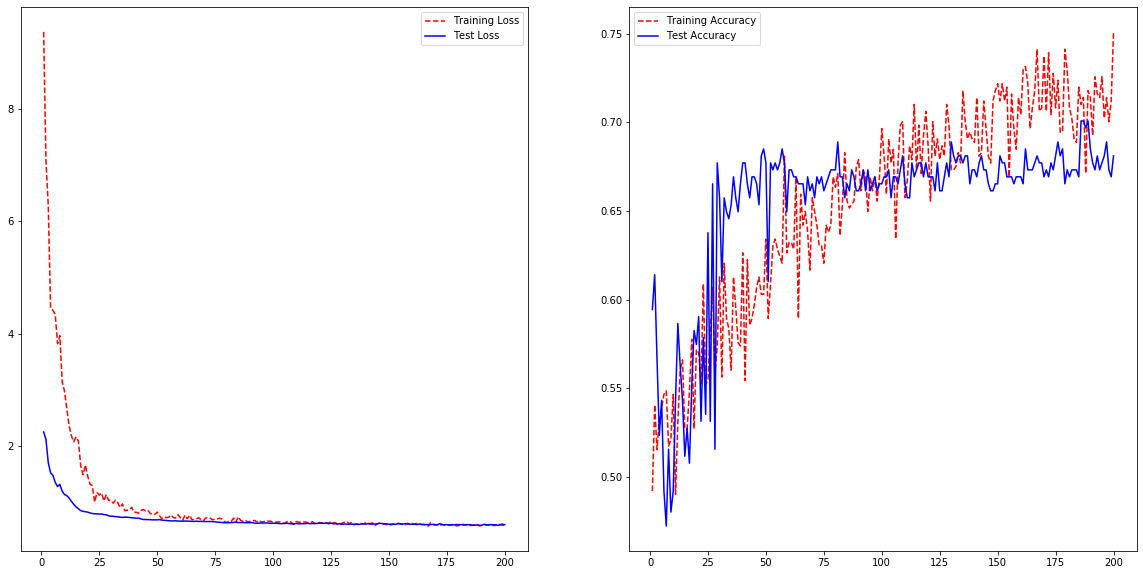

In [91]:
import matplotlib.pyplot as plt

# Get training and test loss/accuracy histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--')
ax1.plot(epoch_count, test_loss, 'b-')
ax1.legend(['Training Loss', 'Test Loss'])

# Visualize accuracy  history
ax2.plot(epoch_count, training_acc, 'r--')
ax2.plot(epoch_count, test_acc, 'b-')
ax2.legend(['Training Accuracy', 'Test Accuracy'])

fig.show();

In [92]:
model.save('model.h5')
model.save_weights('model_weights.h5')

In [93]:
from keras.models import load_model

my_model = load_model('model.h5')
my_model.load_weights('model_weights.h5')

In [98]:
my_model.evaluate(X_test.values, y_test.values)

8/8 [==============================] - 0s 703us/step - loss: 0.5943 - accuracy: 0.6811


[0.5942846536636353, 0.6811023354530334]

## 4. Recurrent Neural Networks - A Quick Overview

Some examples:
* https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
* https://towardsdatascience.com/a-practical-guide-to-rnn-and-lstm-in-keras-980f176271bc
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/